# Library import

In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
from bw_temporalis import easy_timedelta_distribution, TemporalisLCA
import bw_processing as bwp
from utilities import *
import warnings

# Set project and databases

In [7]:
#project_backup_directory = '/Users/jeromea/Downloads/brightway2-project-tictacthree-backup.12-October-2023-06-16PM.tar.gz'
#bi.backup.restore_project_directory(project_backup_directory)

In [8]:
bd.projects.set_current('tictacthree')

In [9]:
bd.databases

Databases dictionary with 6 object(s):
	biosphere3
	ecoinvent-3.9-cutoff
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2020
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2030
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2040
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2050

In [10]:
bd.projects.twofive

True

In [4]:
def generate_simple_database(year, share_of_wind_in_electricity_mix, generated_electricity_over_lifetime=1000):
    """
    Write in the project a simple database for our testing for a given year.

    :param year: Year of the database.
    :param share_of_wind_in_electricity_mix: Share of wind electricity in the dummy electricity mix.
    :param generated_electricity_over_lifetime: Generated electricity by the wind turbine over its lifetime.
    :return: Database with the name 'wind-electricity-year'.
    """
    database_name = 'wind-example-'+str(year)
    
    if database_name in list(bd.databases):
        del bd.databases[database_name]
        
    bd.Database(database_name).write({
        (database_name, "CO2"): {
            "type": "emission",
            "name": "carbon dioxide",
            "unit": "kilogram",
        },
        (database_name, "coal"): {
            "type": "emission",
            "name": "coal",
            "unit": "kilogram",
        },
        (database_name, 'electricity-mix'): {
            'name': 'Electricity mix',
            'unit': 'kilowatt hour',
            'exchanges': [
                {
                    'input': (database_name, 'electricity-production-wind'),
                    'amount': share_of_wind_in_electricity_mix,
                    'type': 'technosphere',
                },
                {
                    'input': (database_name, 'electricity-production-coal'),
                    'amount': 1-share_of_wind_in_electricity_mix,
                    'type': 'technosphere',
                },
            ]
        },
        (database_name, 'electricity-production-coal'): {
            'name': 'Electricity production, coal',
            'unit': 'kilowatt hour',
            'exchanges': [
                {
                    'input': (database_name, 'coal'),
                    'amount': 1,
                    'type': 'biosphere',
                },
                {
                    'input': (database_name, 'CO2'),
                    'amount': 1,
                    'type': 'biosphere',
                },
            ]
        },
        (database_name, 'electricity-production-wind'): {
            'name': 'Electricity production, wind',
            'unit': 'kilowatt hour',
            'exchanges': [
                {
                    'input': (database_name, 'electricity-production-wind'),
                    'amount': 1,
                    'type': 'production',
                },
                {
                    'input': (database_name, 'wind-turbine-construction'),
                    'amount': 1/generated_electricity_over_lifetime,
                    'type': 'technosphere',
                    'temporal_distribution': easy_timedelta_distribution(
                        start=-5,
                        end=0,
                        resolution="Y",  # M for months, Y for years, etc.
                        steps=6,
                    ),
                },
                # maybe add maintenance, oil changes, ...
            ]
        },
        (database_name, 'wind-turbine-construction'): {
            'name': 'Wind turbine construction',
            'unit': 'unit',
            'exchanges': [
                {
                    'input': (database_name, 'wind-turbine-construction'),
                    'amount': 1,
                    'type': 'production'
                },
                {
                    'input': (database_name, 'electricity-mix'),
                    'amount': 1,
                    'type': 'technosphere',
                },
                {
                    'input': (database_name, 'eol-wind'),
                    'amount': 1,
                    'type': 'technosphere',
                    # 'temporal_distribution': easy_timedelta_distribution(
                    #     start=0,
                    #     end=20,
                    #     resolution="Y",  # M for months, Y for years, etc.
                    #     steps=10,
                    # ),
                },
                # aggregate the rest to direct co2 emissions
                {
                    'input': (database_name, 'CO2'),
                    'amount': 1,
                    'type': 'biosphere',
                }
            ]
        },
        (database_name, 'eol-wind'): {
            'name': "End-of-life, wind turbine",
            'unit': 'unit',
            'exchanges': [
                {
                    'input': (database_name, 'eol-wind'),
                    'amount': 1,
                    'type': 'production',
                },
                # aggregate the rest to direct co2 emissions
                {
                    'input': (database_name, 'CO2'),
                    'amount': 1,
                    'type': 'biosphere',
                }
            ]
        },
    })

In [5]:
generate_simple_database(2020, 0.3)
generate_simple_database(2035, 0.5)
generate_simple_database(2050, 0.7)

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 6808.94it/s]

Vacuuming database 


Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]

Vacuuming database 


# LCA method

In [6]:
bd.Method(("GWP", "wind-example-2020")).write([
    (('wind-example-2020', "CO2"), 1),
])

# Patch for setting exchanges in the future

In [7]:
exchange_output = ('wind-example-2035', 'electricity-production-wind')
old_exchange_input = ('wind-example-2035', 'wind-turbine-construction')
new_exchange_input = ('wind-example-2020', 'wind-turbine-construction')
new_exchange_input_amount = 0.002

In [8]:
dp = safety_razor(
    consumer=exchange_output,
    previous_producer=old_exchange_input, 
    new_producer=new_exchange_input, 
)

In [9]:
demand = {('wind-example-2020', 'electricity-production-wind'): 1, ('wind-example-2035', 'electricity-production-wind'): 1}
ia = ("GWP", "wind-example-2020")
fu, data_objs, remapping = bd.prepare_lca_inputs(demand=demand, method=ia)

# LCA calculations

In [10]:
lca_bf_patch = bc.LCA(fu, data_objs=data_objs, remapping_dicts=remapping)
lca_bf_patch.lci()
lca_bf_patch.lcia()
print(lca_bf_patch.score)

0.0027008103595007197


In [11]:
lca = bc.LCA(fu, data_objs=data_objs + [dp], remapping_dicts=remapping)
lca.lci()
lca.lcia()
lca.score

0.005401620590719837

# Temporalis

In [12]:
tlca = TemporalisLCA(lca_bf_patch)

Starting graph traversal
Calculation count: 4


In [13]:
tl = tlca.build_timeline()

In [14]:
tl_df = tl.build_dataframe()

In [15]:
tl_df

,date,amount,flow,activity
0,2018-10-12 03:14:08,0.000167,113,118
1,2018-10-12 03:14:08,0.000117,113,116
2,2018-10-12 03:14:08,0.000167,113,119
3,2019-10-12 09:03:20,0.000167,113,118
4,2019-10-12 09:03:20,0.000117,113,116
5,2019-10-12 09:03:20,0.000167,113,119
6,2020-10-11 14:52:32,0.000117,113,116
7,2020-10-11 14:52:32,0.000167,113,119
8,2020-10-11 14:52:32,0.000167,113,118
9,2021-10-11 20:41:44,0.000167,113,119


<Axes: xlabel='date', ylabel='amount'>

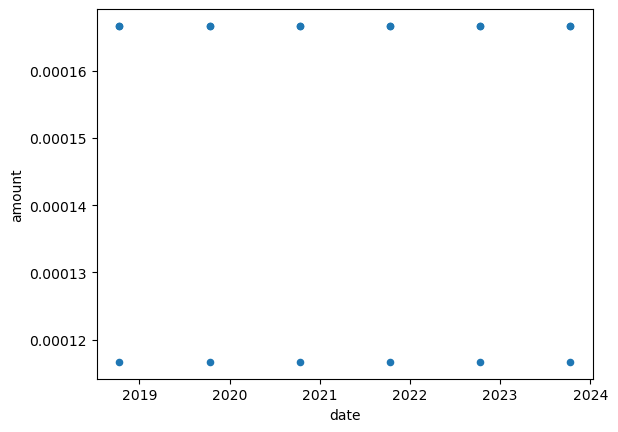

In [16]:
tl.df.plot(x="date", y="amount", kind="scatter")

In [17]:
tl_dt = tl.add_metadata_to_dataframe(database_labels=["wind-example-2020"], fields=['name', 'unit', 'location', 'categories'])

In [18]:
tl_dt

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,2018-10-12 03:14:08,0.000167,113,118,Wind turbine construction,unit,carbon dioxide,kilogram
1,2018-10-12 03:14:08,0.000117,113,116,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram
2,2018-10-12 03:14:08,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
3,2019-10-12 09:03:20,0.000167,113,118,Wind turbine construction,unit,carbon dioxide,kilogram
4,2019-10-12 09:03:20,0.000117,113,116,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram
5,2019-10-12 09:03:20,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
6,2020-10-11 14:52:32,0.000117,113,116,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram
7,2020-10-11 14:52:32,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
8,2020-10-11 14:52:32,0.000167,113,118,Wind turbine construction,unit,carbon dioxide,kilogram
9,2021-10-11 20:41:44,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram


In [107]:
tl = tlca.build_timeline(node_timeline=True)
tl.build_dataframe()
tl_df = tl.add_metadata_to_dataframe(database_labels=["wind-example-2020"], fields=['name', 'unit'])

C:\Users\jeromea\AppData\Local\Continuum\anaconda3\envs\tictac\lib\site-packages\bw_temporalis\lca.py:129: UserWarning: This functionality is experimental, and will change.
You have been warned.
  warnings.warn(


# Interpolation

## First: nearest year

In [20]:
def add_column_nearest_year_on_timeline(tl_df, dates_list):
    """
    Add a column to a timeline with the year of the database, within the list of year of available databases, 
    that is the nearest to the date in the timeline.

    :param tl_df: Timeline as a dataframe.
    :param dates_list: List of years of the available databases.
    
    :return: Timeline as a dataframe with a column 'nearest_year' (int64) added.
    -------------------
    Example:
    >>> dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2022", "%Y"),
        datetime.strptime("2025", "%Y"),
    ]
    >>> add_column_nearest_year_on_timeline(tl_df, dates_list)
    """
    if "date" not in list(tl_df.columns):
        raise ValueError("The timeline does not contain dates.")
    tl_df['nearest_year'] = tl_df['date'].apply(lambda x: find_closest_date(x, dates_list).year)
    return tl_df

In [21]:
dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2035", "%Y"),
        datetime.strptime("2050", "%Y"),
    ]

In [22]:
add_column_nearest_year_on_timeline(tl_df, dates_list)

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit,nearest_year
0,2018-10-12 03:14:08,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,2020
1,2018-10-12 03:14:08,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,2020
2,2018-10-12 03:14:08,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,2020
3,2018-10-12 03:14:08,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,2020
4,2019-10-12 09:03:20,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,2020
5,2019-10-12 09:03:20,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,2020
6,2019-10-12 09:03:20,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,2020
7,2019-10-12 09:03:20,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,2020
8,2020-10-11 14:52:32,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,2020
9,2020-10-11 14:52:32,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,2020


## Second: interpolation

In [67]:
dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2035", "%Y"),
        datetime.strptime("2050", "%Y"),
    ]

In [88]:
date_test = datetime(2019,10,11)
diff_test = [date_test - x for x in dates_list]

if timedelta(0) in diff_test:
    print("Exact match")
    exact_match = dates_list[diff_test_bis.index(timedelta(0))]
else:
    closest_lower = min(
        dates_list, 
        key=lambda date: abs(date_test - date) if (date_test - date) > timedelta(0) else timedelta.max
    )
    closest_higher = min(
        dates_list, 
        key=lambda date: abs(date_test - date) if (date_test - date) < timedelta(0) else timedelta.max
    )
closest_higher

datetime.datetime(2020, 1, 1, 0, 0)

In [89]:
int((date_test - closest_lower).total_seconds())/int((closest_higher - closest_lower).total_seconds())

ZeroDivisionError: division by zero

In [109]:
def get_weights_for_interpolation_between_nearest_years(date, dates_list, interpolation_type="linear"):
    """
    Find the nearest dates (before and after) a given date in a list of dates and calculate the interpolation weights.

    :param date: Target date.
    :param dates_list: List of years of the available databases.
    :param interpolation_type: Type of interpolation between the nearest lower and higher dates. For now, 
    only "linear" is available.
    
    :return: Dictionary with years of the available databases to use as keys and the weights for interpolation as values.
    -------------------
    Example:
    >>> dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2022", "%Y"),
        datetime.strptime("2025", "%Y"),
    ]
    >>> date_test = datetime(2021,10,11)
    >>> add_column_interpolation_weights_on_timeline(date_test, dates_list, interpolation_type="linear")
    """
    dates_list = sorted (dates_list)
    
    diff_dates_list = [date - x for x in dates_list]
    if timedelta(0) in diff_dates_list:
        exact_match = dates_list[diff_dates_list.index(timedelta(0))]
        return {exact_match.year: 1}

    closest_lower = min(
        dates_list, 
        key=lambda x: abs(date - x) if (date - x) > timedelta(0) else timedelta.max
    )
    closest_higher = min(
        dates_list, 
        key=lambda x: abs(date - x) if (date - x) < timedelta(0) else timedelta.max
    )

    if closest_lower == closest_higher:
        warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)
        return {closest_lower.year: 1}
        
    if interpolation_type == "linear":
        weight = int((date - closest_lower).total_seconds())/int((closest_higher - closest_lower).total_seconds())
    else:
        raise ValueError(f"Sorry, but {interpolation_type} interpolation is not available yet.")
    return {closest_lower.year: weight, closest_higher.year: 1-weight}

In [102]:
get_weights_for_interpolation_between_nearest_years(date_test, dates_list)

C:\Users\jeromea\AppData\Local\Temp\ipykernel_12048\2354799543.py:20: Warning: Date outside the range of dates covered by the databases.
  warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)


{2020: 1}

In [103]:
tl_df['interpolation'] = tl_df['date'].apply(lambda x: get_weights_for_interpolation_between_nearest_years(x, dates_list))

C:\Users\jeromea\AppData\Local\Temp\ipykernel_12048\2354799543.py:20: Warning: Date outside the range of dates covered by the databases.
  warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)


In [106]:
def add_column_interpolation_weights_on_timeline(tl_df, dates_list, interpolation_type="linear"):
    """
    Add a column to a timeline with the weights for an interpolation between the two nearest dates,
    from the list of dates from the available databases.

    :param tl_df: Timeline as a dataframe.
    :param dates_list: List of years of the available databases.
    :param interpolation_type: Type of interpolation between the nearest lower and higher dates. For now, 
    only "linear" is available.
    
    :return: Timeline as a dataframe with a column 'interpolation_weights' (object:dictionnary) added.
    -------------------
    Example:
    >>> dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2022", "%Y"),
        datetime.strptime("2025", "%Y"),
    ]
    >>> add_column_interpolation_weights_on_timeline(tl_df, dates_list, interpolation_type="linear")
    """
    if "date" not in list(tl_df.columns):
        raise ValueError("The timeline does not contain dates.")
    tl_df['interpolation_weights'] = tl_df['date'].apply(lambda x: get_weights_for_interpolation_between_nearest_years(x, dates_list, interpolation_type))
    return tl_df

In [108]:
add_column_interpolation_weights_on_timeline(tl_df, dates_list)

C:\Users\jeromea\AppData\Local\Temp\ipykernel_12048\2354799543.py:20: Warning: Date outside the range of dates covered by the databases.
  warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)


,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit,interpolation_weights
0,2018-10-12 03:14:08,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,{2020: 1}
1,2018-10-12 03:14:08,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,{2020: 1}
2,2018-10-12 03:14:08,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,{2020: 1}
3,2018-10-12 03:14:08,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,{2020: 1}
4,2019-10-12 09:03:20,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,{2020: 1}
5,2019-10-12 09:03:20,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,{2020: 1}
6,2019-10-12 09:03:20,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,{2020: 1}
7,2019-10-12 09:03:20,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,{2020: 1}
8,2020-10-11 14:52:32,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,"{2020: 0.05194740186435751, 2035: 0.9480525981..."
9,2020-10-11 14:52:32,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,"{2020: 0.05194740186435751, 2035: 0.9480525981..."
